<a href="https://colab.research.google.com/github/Nadezda-Sut/EEG/blob/main/MNE_Connectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 45.3 MB/s eta 0:00:00


In [2]:
!pip install autoreject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:

!pip install -U mne-connectivity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.7 MB/s eta 0:00:00


In [4]:
import matplotlib
import pathlib
import mne
import pandas as pd
import numpy as np 
from autoreject  import AutoReject
ar = AutoReject()
from mne_connectivity import spectral_connectivity_epochs



In [ ]:
#main_folder = pathlib.Path().cwd()

#input_folder = pathlib.Path('D:/eeg_connectivity') 
#output_folder = pathlib.Path('D:/eeg_connectivity/output')



#files = [file for file in input_folder.iterdir() if file.suffix == '.fif']

#files = 'D:/eeg_connectivity/VatEvgDoICA.set'


In [127]:
from google.colab import drive
drive.mount('/content/gdrive')
     

# path to file in google drive

file_path = "/content/gdrive/My Drive/Colab Notebooks/VatEvgDoICA.set"
     

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [72]:
input_file = '/content/gdrive/My Drive/Colab Notebooks/VatEvgDoICA.set'
output_file = '/content/gdrive/My Drive/Colab Notebooks/VatEvgDoICA.fif'

# Read the EEG data from the input file
raw = mne.io.read_raw_eeglab(input_file, preload=True)

# Save the EEG data to the output file in FIF format
raw.save(output_file, overwrite=True)

Reading /content/gdrive/My Drive/Colab Notebooks/VatEvgDoICA.fdt
Reading 0 ... 61924  =      0.000 ...   241.891 secs...
Overwriting existing file.
Writing /content/gdrive/My Drive/Colab Notebooks/VatEvgDoICA.fif
Closing /content/gdrive/My Drive/Colab Notebooks/VatEvgDoICA.fif


<ipython-input-72-664dc7b7bada>:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(input_file, preload=True)
<ipython-input-72-664dc7b7bada>:5: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(input_file, preload=True)
<ipython-input-72-664dc7b7bada>:8: RuntimeWarning: This filename (/content/gdrive/My Drive/Colab Notebooks/VatEvgDoICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


[done]


In [73]:
file = '/content/gdrive/My Drive/Colab Notebooks/VatEvgDoICA.fif'

# Convert .ced to .csv 

In [74]:
import csv
import re

def convert_ced_to_csv(ced_file, csv_file):
    # Open the .ced file for reading
    with open(ced_file, 'r') as ced:
        # Create a CSV writer object
        csv_writer = csv.writer(csv_file)
        
        # Write the header row
        csv_writer.writerow(["Electrode Label", "X", "Y", "Z"])
        
        # Read the .ced file line by line
        for line in ced:
            # Parse the electrode label and coordinates from each line
            match = re.match(r'(\w+)\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)', line)
            if match:
                electrode_label = match.group(1)
                x_coord = match.group(2)
                y_coord = match.group(3)
                z_coord = match.group(4)
                
                # Write the electrode information as a row in the CSV file
                csv_writer.writerow([electrode_label, x_coord, y_coord, z_coord])

# Example usage: Convert example.ced to example.csv
ced_file = '/content/gdrive/My Drive/Colab Notebooks/Channels.ced'
csv_file = '/content/gdrive/My Drive/Colab Notebooks/Channels.csv'

with open(csv_file, 'w', newline='') as output_csv:
    convert_ced_to_csv(ced_file, output_csv)

In [75]:
montage = mne.channels.read_custom_montage("/content/gdrive/My Drive/Colab Notebooks/Channels.csv")

In [76]:
epochs_duration = 3.
epochs_overlap = 0.5

con_methods = ['wpli']
#, 'imcoh', 'ciplv', 'ppc', 'coh' 
con_freqs = ['4-30','4-8','8-13','13-20', '20-30', '8-10', '10-13']

In [77]:
freqs_min = [int(x.split('-')[0]) for x in con_freqs]
freqs_max = [int(x.split('-')[1]) for x in con_freqs]
sen_or_sour = 'sensors'

In [78]:
def epoching(raw, duration, overlap):
  tmin = 0
  tmax = duration
  duration = duration - overlap
  events=mne.make_fixed_length_events(raw, id=1,duration=duration) 
  picks = mne.pick_types( raw.info , meg=False, eeg=True, eog=False) 
  epochs = mne.Epochs(raw, events=events, tmin=tmin, baseline = (0, 0), 
                      tmax=tmax, picks=picks, reject_by_annotation=True)
  epochs.drop_bad() 
  return epochs


In [79]:
raw = mne.io.read_raw_fif(file, preload=True)

Opening raw data file /content/gdrive/My Drive/Colab Notebooks/VatEvgDoICA.fif...
    Range : 0 ... 61924 =      0.000 ...   241.891 secs
Ready.
Reading 0 ... 61924  =      0.000 ...   241.891 secs...


<ipython-input-79-8f81574964f6>:1: RuntimeWarning: This filename (/content/gdrive/My Drive/Colab Notebooks/VatEvgDoICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True)


In [80]:
epochs = epoching(raw,4.,0.5)


Not setting metadata
69 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 69 events and 1025 original time points ...
1 bad epochs dropped


In [81]:
output_folder = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks')

In [82]:
person = 'VatEvgDo_matrix'
freqs = raw.info['sfreq'] 

In [83]:
def calculate_conn(data, con_methods, sfreq, freqs_min, freqs_max, node_names, person, output_folder):

    for con_method in con_methods:
        con = spectral_connectivity_epochs(data, method = con_methods,
                                                                                       mode = 'multitaper',
                                                                                       sfreq=sfreq, fmin=freqs_min,
                                                                                       fmax = freqs_max, faverage = True,
                                                                                       mt_adaptive = True, n_jobs = -1)
        con = con.get_data(output='dense')
    
    for shp in range(0, con.shape[2]):
        output_filename = f'{output_folder}/{person}_{sen_or_sour}_{con_method}.csv'
        savefile = pd.DataFrame(np.array(con[:,:,shp]))
        savefile.columns = savefile.index = node_names

        savefile.to_csv(output_filename)



In [84]:
calculate_conn(epochs, con_methods, epochs.info['sfreq'], freqs_min, freqs_max, epochs.info['ch_names'], person, output_folder)

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1596 connections
    using t=0.000s..4.000s for estimation (1025 points)
    computing connectivity for the bands:
     band 1: 4.2Hz..30.0Hz (104 points)
     band 2: 4.2Hz..8.0Hz (16 points)
     band 3: 8.2Hz..13.0Hz (20 points)
     band 4: 13.2Hz..20.0Hz (28 points)
     band 5: 20.2Hz..30.0Hz (40 points)
     band 6: 8.2Hz..10.0Hz (8 points)
     band 7: 10.2Hz..13.0Hz (12 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing connectivity for epochs 1..1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 2..2


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 3..3


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 4..4
    computing connectivity for epochs 5..5


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 6..6
    computing connectivity for epochs 7..7


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 8..8
    computing connectivity for epochs 9..9


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 10..10
    computing connectivity for epochs 11..11


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 12..12
    computing connectivity for epochs 13..13


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 14..14
    computing connectivity for epochs 15..15


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 16..16
    computing connectivity for epochs 17..17


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 18..18
    computing connectivity for epochs 19..19


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 20..20
    computing connectivity for epochs 21..21


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 22..22
    computing connectivity for epochs 23..23


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 24..24
    computing connectivity for epochs 25..25


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 26..26
    computing connectivity for epochs 27..27


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 28..28
    computing connectivity for epochs 29..29


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 30..30
    computing connectivity for epochs 31..31


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 32..32
    computing connectivity for epochs 33..33


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 34..34
    computing connectivity for epochs 35..35


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 36..36
    computing connectivity for epochs 37..37


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 38..38
    computing connectivity for epochs 39..39


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 40..40
    computing connectivity for epochs 41..41


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 42..42
    computing connectivity for epochs 43..43


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 44..44
    computing connectivity for epochs 45..45


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 46..46
    computing connectivity for epochs 47..47


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 48..48
    computing connectivity for epochs 49..49


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 50..50
    computing connectivity for epochs 51..51


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 52..52
    computing connectivity for epochs 53..53


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 54..54
    computing connectivity for epochs 55..55


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 56..56
    computing connectivity for epochs 57..57


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 58..58
    computing connectivity for epochs 59..59


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 60..60
    computing connectivity for epochs 61..61


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 62..62
    computing connectivity for epochs 63..63


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 64..64
    computing connectivity for epochs 65..65


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 66..66
    computing connectivity for epochs 67..67


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 68..68
    assembling connectivity matrix
[Connectivity computation done]


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [85]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [128]:
file_matrix = '/content/gdrive/My Drive/Colab Notebooks/a.csv'
file_labels = '/content/gdrive/My Drive/Colab Notebooks/electrodes.csv'

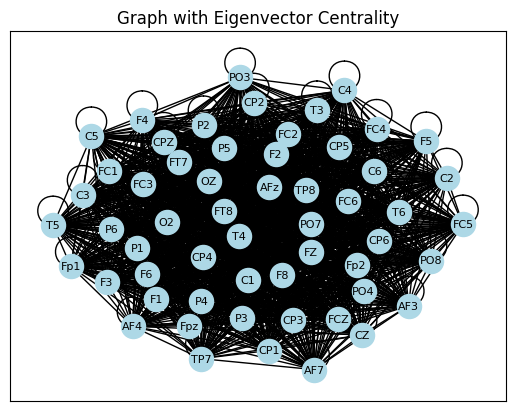

In [142]:
# Load adjacency matrix from CSV file
adjacency_matrix = np.loadtxt(file_matrix, delimiter=',', skiprows=1)

# Load electrode labels from CSV file
try:
    electrode_labels = pd.read_csv(file_labels)['electrode_labels'].tolist()
except KeyError as e:
    print(f"Error: Column '{e.args[0]}' not found in the electrode labels CSV file.")
    exit(1)

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# Set the electrode labels as node attributes
labels = {i: label for i, label in enumerate(electrode_labels)}
nx.set_node_attributes(G, labels, 'label')

# Calculate eigenvector centrality
centrality = nx.eigenvector_centrality(G)

# Visualize the graph
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=False, node_color='lightblue')
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=8)
plt.title("Graph with Eigenvector Centrality")
plt.show()